# Pan-sharpening
Many multispectral sensors (MS) used for Earth observation in the optical bands collect data in the RGB and NIR bands to extract information that is related to the reflectance of the Earth surface on these bands. The spectral resolution of a platform is related to the number of bands in the optical spectrum and to the width of the bands. The narrower the width of a band the less energy the sensor can collect in the unit time and so its spatial resolution. In order to achieve the required spectral and spatial resolution many satellite platform add a panchromatic (PAN) sensor that collects the light from the full optical spectrum and also part of the near infrared band. Beacuse of the larger width the spatial resolution of the PAN band is usually more than two times the spatial resolution of the optical bands. The PAN band can be used to process the MS bands so that their spatial resolution will be the same as the PAN band. Many algorthms have been developed to implement the pan-sharpening technique with different results in terms of the quality of the output. In this notebook we use the imagery from Landsat 9: the tree RGB bands with 30 m spatial resolution, and the PAN band with 15 m resolution. We will use the pan-sharpening technique to achieve a resolution of 15 m for the three RGB bands. 

In [1]:
import os
#import glob
import numpy as np
import math
from osgeo import gdal, osr, ogr
from PIL import Image, ImageDraw
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
print("NumPy version: %s"%np.__version__)
print("GDAL version: %s"%gdal.__version__)
print("GeoPandas version: %s"%gpd.__version__)

NumPy version: 1.23.1
GDAL version: 3.5.1
GeoPandas version: 0.11.1


## Landsat 9
The [Landsat 9](https://www.usgs.gov/landsat-missions/landsat-9) satellite carries the Optical Land Imager 2 (OLI-2) that collects the sun light reflected by the Earth surface in 9 bands, from the visible part of the spectrum to the short-wavelength infrared. The bands 2, 3, and 4 represent the blue, green, and red bands of the visible spectrum respectively. The spatial resolution for each of these bands is 30 m. The OLI_2 instrument uses 14 bits per pixel for each band so the minimum number of bytes to store it is 2 (GDAL GDT DataType UInt16). The data from the Landsat 9 mission, like for the previous ones, are realised under an open data policy by the USGS and can be accessed using a web browser from the [USGS Earth Explorer](https://earthexplorer.usgs.gov/). From the browser the user can select the area of interest, the dataset from the Landsat Collection 2 Level-1 that contains the RGB bands and the panchromatic band as separate files, the date range and the cloud cover range.  

![USGS Earth Explorer](images/usgs_earth_explorer.jpg)

We select an area (red polygon) over Southern Italy with a cloud cover less than 25% and download the products from path 190 and row 031 of the World Reference System-2. The products are the RGB and the PAN bands. We use only a subset of the images that covers the towns of Gaeta and Formia in the Italian province of Latina.

In [2]:
path = 'data/raster/Landsat/Italy/'
band2_fn = path + 'LC09_L1TP_190031_B2_subset.TIF'
band3_fn = path + 'LC09_L1TP_190031_B3_subset.TIF'
band4_fn = path + 'LC09_L1TP_190031_B4_subset.TIF'
band8_fn = path + 'LC09_L1TP_190031_B8_subset.TIF'

Image format: TIFF
Shape (rows, cols): (667, 667)
Mode: I;16


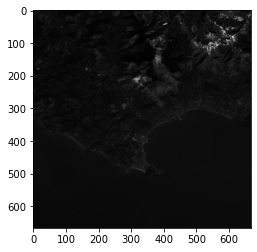

In [3]:
im_band2 = Image.open(band2_fn)
print('Image format: {}\nShape (rows, cols): {}\nMode: {}'.format(im_band2.format, im_band2.size, im_band2.mode))
plt.imshow(im_band2, cmap='gray')

We print some metadata to see the coordinate sytsem, the origin of the image, and its extent. The coordinate system is the projected Universal Transverse Mercator, zone 33N whose EPSG code is [EPSG:32633](https://epsg.io/32633)

In [4]:
band2_ds = gdal.Open(band2_fn)
rows = band2_ds.RasterXSize
cols = band2_ds.RasterYSize
print('Rows: {0}\nColumns: {1}'.format(rows, cols))

Rows: 667
Columns: 667


In [5]:
band2_ds.GetProjection()

'PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]'

In [6]:
x_origin, x_pixel_resolution, row_rotation, y_origin, column_rotation, y_pixel_resolution = band2_ds.GetGeoTransform()
print('x origin: {} m.\ny origin: {} m.\nrow rot.: {}\ncolumn rot.: {}\nx pixel res.: {} m.\ny pixel res: {} m.'.format(x_origin, 
                                                                                                                        y_origin, 
                                                                                                                        row_rotation, 
                                                                                                                        column_rotation, 
                                                                                                                        x_pixel_resolution, 
                                                                                                                        y_pixel_resolution))

x origin: 369885.0 m.
y origin: 4577715.0 m.
row rot.: 0.0
column rot.: 0.0
x pixel res.: 30.0 m.
y pixel res: -30.0 m.


In [9]:
x_size = rows * x_pixel_resolution
y_size = cols * x_pixel_resolution
print('X size: {:0.1f} Km\nY size: {:0.1f} Km'.format(x_size / 1000, y_size / 1000))

X size: 20.0 Km
Y size: 20.0 Km


Some statistics about the distribution of the pixel values. The Landsat 9 imagery uses 14 bits for quantization so the values can range from 0 to $2^{14} = 16384$. The values have been rescaled to use 2 bytes (16 bits)

In [10]:
band2 = band2_ds.GetRasterBand(1)
mean, stdev = band2.ComputeBandStats(True)
min, max = band2.ComputeRasterMinMax(True)
print('Pixel min value: {}\nPixel max value: {}'.format(min, max))
print('Pixel mean value: {:0.1f}\nPixel value Std.Dev.: {:0.1f}'.format(mean, stdev))

Pixel min value: 7191.0
Pixel max value: 26340.0
Pixel mean value: 8274.8
Pixel value Std.Dev.: 823.5


## RGB true color image
In order to see the RGB colors we put the three RGB bands in the same GeoTIFF file. We create a new GeoTIFF file with three bands. Before copying the data into the space allocated we change the values of the bands from integer to float, normalized between 0 and 1. We use the same projection and origin of the three RGB bands.

In [11]:
gtiff_driver = gdal.GetDriverByName('GTiff')
rgb_ds = gtiff_driver.Create(path + 'LC09_L1TP_190031_RGB_subset.tif', band2.XSize, band2.YSize, 3, band2.DataType)
rgb_ds.SetProjection(band2_ds.GetProjection())
rgb_ds.SetGeoTransform(band2_ds.GetGeoTransform())

0

In [12]:
def normalize(array):
    '''
    Normalize: normalize a numpy array so that all values are between 0 and 1
    '''
    array_min, array_max = array.min(), array.max()
    array_norm = (array - array_min) / (array_max - array_min)
    return array_norm


We copy the band 2 (Blue) in the 3rd band of the color image

In [13]:
from skimage import exposure
band2_data = band2_ds.ReadAsArray()
band2_data_norm = normalize(band2_data)
rgb_band = rgb_ds.GetRasterBand(3)
rgb_band.WriteArray(band2_data)

0

We copy the band 3 (Green) in 2nd band of the color image

In [14]:
band3_ds = gdal.Open(band3_fn)
band3_data = band3_ds.ReadAsArray()
rgb_band = rgb_ds.GetRasterBand(2)
rgb_band.WriteArray(band3_data)

0

Finally we copy the band 4 (Red) in the 1st band of the color image

In [15]:
band4_ds = gdal.Open(band4_fn)
band4_data = band4_ds.ReadAsArray()
rgb_band = rgb_ds.GetRasterBand(1)
rgb_band.WriteArray(band4_data)

0

In [16]:
rgb_ds.FlushCache() 

In [17]:
rgb_ds.RasterCount

3

In [18]:
del rgb_ds

(667, 667, 3)


C:\Users\Luigi\Anaconda3\envs\wekeo\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


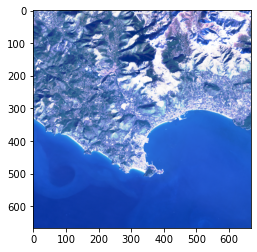

In [37]:
from skimage import io
im_natcol = io.imread(path + 'LC09_L1TP_190031_RGB_subset.tif')
im_normalized = exposure.equalize_hist(normalize(im_natcol))
plt.imshow(im_normalized)

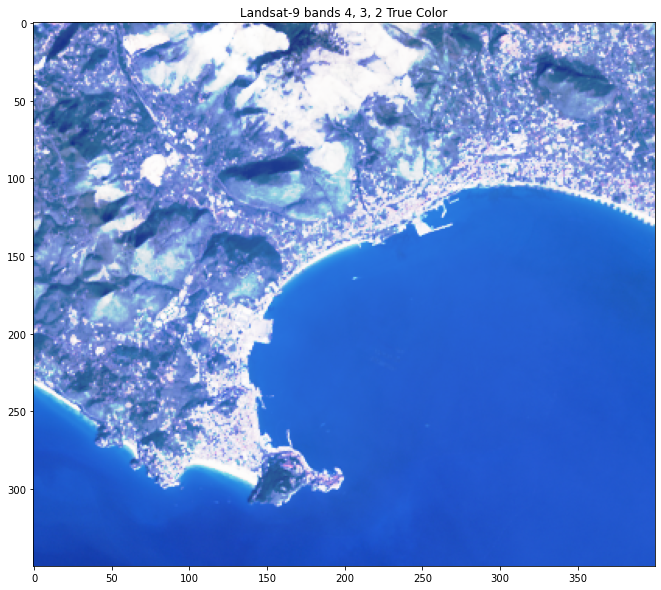

In [38]:
fig, ax = plt.subplots(1, figsize=(12, 10))
ax.set_title('Landsat-9 bands 4, 3, 2 True Color')
plt.imshow(im_normalized[200:550, 200:600, :])

## Panchromatic band
We use the panchromatic band to pan-sharpen the MS bands. Once we apply a pan-sharpening algorithm to any of the MS bands we should get a new band with the same resolution of the panchromatic band.

In [42]:
pan_ds = gdal.Open(band8_fn)
pan_ds.GetProjection()

'PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]'

In [22]:
pan_x_origin, pan_x_pixel_res, row_rot, pan_y_origin, column_rot, pan_y_pixel_res = pan_ds.GetGeoTransform()
print('x origin: {} m.\ny origin: {} m.\nrow rot.: {}\ncolumn rot.: {}\nx pixel res.: {} m.\ny pixel res: {} m.'.format(pan_x_origin, 
                                                                                                                        pan_y_origin, 
                                                                                                                        row_rot, 
                                                                                                                        column_rot, 
                                                                                                                        pan_x_pixel_res, 
                                                                                                                        pan_x_pixel_res))

x origin: 369892.5 m.
y origin: 4577707.5 m.
row rot.: 0.0
column rot.: 0.0
x pixel res.: 15.0 m.
y pixel res: 15.0 m.


### Distance between origin of PAN and MS bands

In [23]:
delta_pan_ms_origin_x = pan_x_origin - x_origin
delta_pan_ms_origin_y = pan_y_origin - y_origin
print('Distance PAN and MS origin\nHorizontal: {} m\nVertical: {}'.format(delta_pan_ms_origin_x, delta_pan_ms_origin_y))

Distance PAN and MS origin
Horizontal: 7.5 m
Vertical: -7.5


In [24]:
pan_band = pan_ds.GetRasterBand(1)
min, max = pan_band.ComputeRasterMinMax(True)
mean, stdev = pan_band.ComputeBandStats(True)
print('Pixel min value: {}\nPixel max value: {}'.format(min, max))
print('Pixel mean value: {:0.1f}\nPixel value Std.Dev.: {:0.1f}'.format(mean, stdev))

Pixel min value: 6061.0
Pixel max value: 26034.0
Pixel mean value: 7204.1
Pixel value Std.Dev.: 1156.4


In [25]:
pan_data = pan_ds.ReadAsArray()
pan_data.shape

(1333, 1333)

In [26]:
pan_data_norm = normalize(pan_data)

## Pan-sharpening
There are many pan-sharpening algorithms, the most simple one is the sample-mean method.

In [27]:
def stretch(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands)
    for i in range(3):
        a = 0 
        b = 255 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t
    return out.astype(np.uint8)

In [28]:
from skimage.transform import rescale
import skimage.color as color

def pansharpen(ms, pan, method='sample_mean', all_data=False):
    
    # get m_bands
    rgb = np.empty((ms.shape[0], ms.shape[1], ms.shape[2])) 
    rgb[:,:,0] = ms[:,:,0] # red
    rgb[:,:,1] = ms[:,:,1] # green
    rgb[:,:,2] = ms[:,:,2] # blue
    
    # scaled them
    rgb_scaled = np.empty((ms.shape[0] * 2, ms.shape[1] * 2, ms.shape[2]))

    for i in range(3):
        img = rgb[:,:,i]
        scaled = rescale(img, (2,2))
        rgb_scaled[:,:,i] = scaled
    
    # check size and crop for pan band
    if pan.shape[0] < rgb_scaled.shape[0]:
        rgb_scaled = rgb_scaled[:pan.shape[0],:, :]
    else:
        pan = pan[:rgb_scaled.shape[0], :]
        
    if pan.shape[1] < rgb_scaled.shape[1]:
        rgb_scaled = rgb_scaled[:,:pan.shape[1], :]
    else:
        pan = pan[:,:rgb_scaled.shape[1]]
        
    R = rgb_scaled[:,:,0]
    G = rgb_scaled[:,:,1]
    B = rgb_scaled[:,:,2]

    image = None

    if method == 'sample_mean':
        r = 0.5 * (R + pan)[:, :, np.newaxis]
        g = 0.5 * (G + pan)[:, :, np.newaxis]
        b = 0.5 * (B + pan)[:, :, np.newaxis]
        
        image = np.concatenate([r,g,b], axis=2)
                
    return image

In [34]:
import tifffile as tiff
IM_ID = '6120_2_2'
ms = tiff.imread('data/raster/Landsat/Italy/LC09_L1TP_190031_RGB_subset.tif'.format(IM_ID))
pan = tiff.imread('data/raster/Landsat/Italy/LC09_L1TP_190031_B8_subset.TIF'.format(IM_ID))

print ('MS shape: ', ms.shape)
print ('PAN shape: ', pan.shape)

MS shape:  (667, 667, 3)
PAN shape:  (1333, 1333)


In [35]:
ms.shape[2]

3

In [47]:
sharpened_mean = pansharpen(ms, normalize(pan), method='sample_mean')
sharpened_mean.shape

(1333, 1333, 3)

We plot the data as an image without geographic information

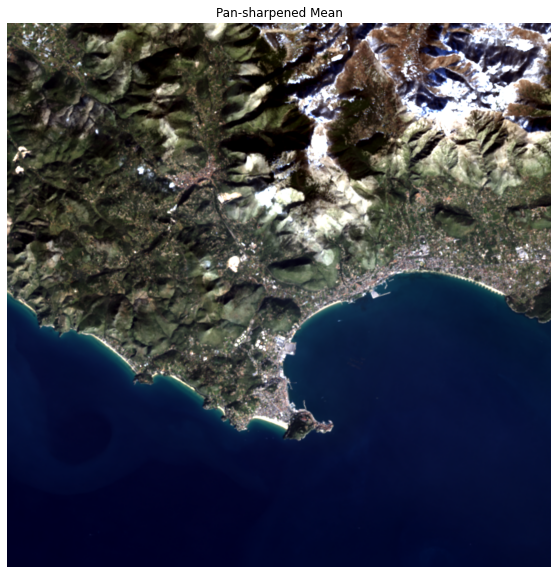

In [54]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 10))
im_data = stretch(sharpened_mean[:,:,:])
ax.imshow(im_data)
ax.set_title('Pan-sharpened Mean')    
ax.axis('off')
plt.show()

We create a GeoTiff file to store the pan-sharpened bands with the geographic information, i.e. reference system and origin.

In [55]:
def create_pan_sharpenend_tif(pan_sharp_fn, data, pan_ds):
    '''
    Create a GeoTiff file from a NumPy array
    pan_sharp_fn: is the GeoTiff file name
    data: is the NumPy multidimensional array (rows, cols, channels)
    pan_ds. is the GDAL data source of the panchromatic band
    '''
    rows = data.shape[0]
    cols = data.shape[1]
    num_bands = data.shape[2]
    gtiff_driver = gdal.GetDriverByName('GTiff')
    pan_sharp_ds = gtiff_driver.Create(pan_sharp_fn, rows, cols, num_bands, pan_ds.GetRasterBand(1).DataType)
    pan_sharp_ds.SetProjection(pan_ds.GetProjection())
    #pan_sharp_ds.SetGeoTransform([x_s, x_pixel_res, 0.0, y_s, 0.0, y_pixel_res])
    pan_sharp_ds.SetGeoTransform(pan_ds.GetGeoTransform())
    for i in range(num_bands):
        pan_sharp_band = pan_sharp_ds.GetRasterBand(i + 1)
        band = data[:,:,i]
        pan_sharp_band.WriteArray(band)
    pan_sharp_ds.FlushCache()
    del pan_sharp_ds

In [56]:
pan_sharp_fn = path + 'pan_sharpened.tif'
create_pan_sharpenend_tif(pan_sharp_fn, sharpened_mean, pan_ds)

We plot again the data to be sure the file has been written correctly. 

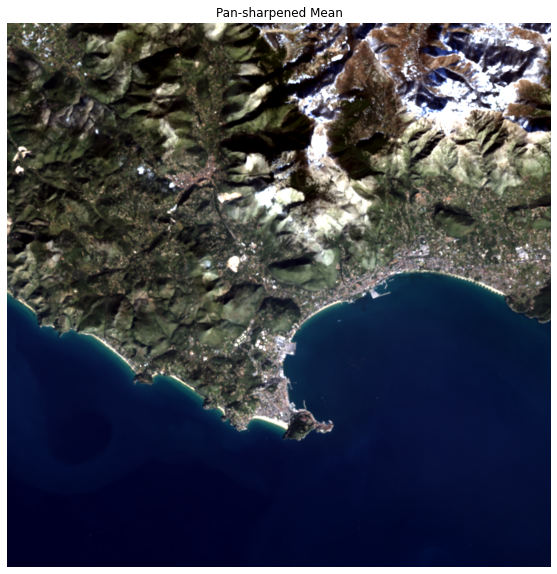

In [57]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 10))
pan_sharp_img = io.imread(pan_sharp_fn)
pan_sharp_normalized_img = stretch(pan_sharp_img)
ax.imshow(pan_sharp_normalized_img)
ax.set_title('Pan-sharpened Mean')    
ax.axis('off')
plt.show()